In [1]:
from __future__ import print_function, division

import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#import matplotlib.pyplot as plt
import time
import json
import pandas as pd
from datetime import datetime
sys.path.insert(0,'../multi_label')
import ImageFileList
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [13]:
#plt.ion()   
article_type = 'dresses'
attribute = "sleeve_length"
batch_size_num = 32
train_file_name = 'multilabel_train.txt'
test_file_name = article_type + '_' +  attribute + '_test.txt'
learning_rate = 0.01
momentum = 0.9
step_size = 4
num_epochs = 20

In [14]:
#ImageFileList = ImageFileList.ImageFileList()
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale( (224,224) ),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale( (224,224) ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [20]:
train_val_list = ['val']

path_to_input_file = {
    'train' :'/rapid_data/myntra/myntra_data/' + article_type + '/multi_label/' + train_file_name ,
    'val': '/rapid_data/myntra/myntra_data/' + article_type + '/' + article_type + '_' + attribute + '/' + test_file_name
    }

df = pd.read_csv(path_to_input_file['train'], header = None, sep =' ')
df.columns = ['path', 'sleeve_style_label','sleeve_length_label','length_label','print_label','neck_label','hemline_label', 'shape_label']
n_classes_sleeve_style = df['sleeve_style_label'].nunique()
n_classes_sleeve_length = df['sleeve_length_label'].nunique()
n_classes_length = df['length_label'].nunique()
n_classes_print = df['print_label'].nunique()
n_classes_neck = df['neck_label'].nunique()
n_classes_hemline = df['hemline_label'].nunique()
n_classes_shape = df['shape_label'].nunique()


path_to_checkpoint = '/rapid_data/myntra/myntra_data/' + article_type + '/multi_label/ckpt_unaug_data/res34_' + str(learning_rate)
image_datasets = {x: ImageFileList.ImageFilelisit_a( flist=path_to_input_file[x],
                                   transform = data_transforms[x])
                  for x in train_val_list}


#train_list = image_datasets['train'].imlist
test_list = image_datasets['val'].imlist

#print (test_list)
#train_labels = list(set( [x[1] for x in train_list]))
test_labels = list(set( [x[1][0] for x in test_list]))
#print ('train_labels' + str (train_labels) )
#print ('test_labels' + str (train_labels) )
'''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
'''
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=False, num_workers=4)
              for x in train_val_list}

In [52]:
test_list[]

11114

In [31]:
# class_names = image_datasets['train'].classes

'''
train_loader = torch.utils.data.DataLoader(
    ImageFilelist(root=".", flist="../place365_challenge/places365_train_challenge.txt",
                  transform=transforms.Compose([transforms.RandomSizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(), normalize,
                                               ])),
    batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True)
'''

print ('Current time and date is: ' + str(datetime.now()) )
print ('The model is being trained for: ' +  article_type + '_' + attribute )
dataset_types = {x: type(image_datasets[x]) for x in train_val_list}
print ('dataset_types: ' + str(dataset_types) )
dataset_sizes = {x: len(image_datasets[x]) for x in train_val_list}
print ('dataset_sizes: ' + str(dataset_sizes) )
#class_names = image_datasets['train'].classes

Current time and date is: 2018-05-04 10:06:04.733344
The model is being trained for: dresses_sleeve_length
dataset_types: {'train': <type 'instance'>, 'val': <type 'instance'>}
dataset_sizes: {'train': 80000, 'val': 11114}


In [45]:
use_gpu = torch.cuda.is_available()
print("checking gpu")
print(use_gpu)

checking gpu
True


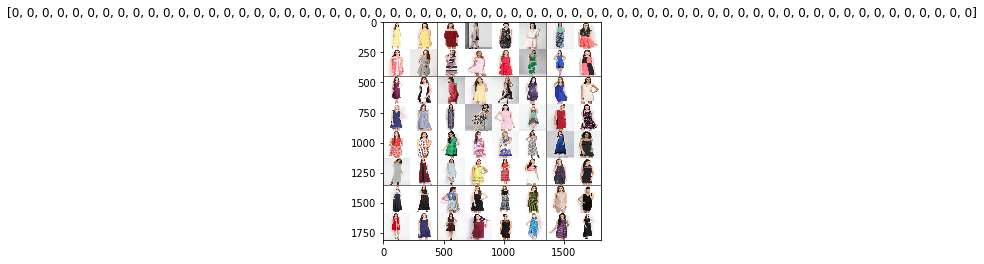

In [33]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = train_labels
# Get a batch of training data
inputs, classes = next(iter(dataloders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [23]:
model_dir = '/rapid_data/myntra/myntra_data/' + article_type + '/' + article_type + '_' + attribute + '/'
model_file = 'ckpt_log_aug_data/res34_0.005/*'
model_path = os.path.join(model_dir, model_file )
model_path =  '/rapid_data/myntra/myntra_data/' + article_type + '/multi_label/ckpt_unaug_data/res34_' + str(learning_rate)+'/*'
list_of_files = glob.glob(model_path) 
model_path = max(list_of_files, key=os.path.getctime)
print ('model_path:'+ str(model_path) )

model_ft = models.resnet34(pretrained=False)
class Branched(nn.Module):

    def __init__(self):
        super(Branched, self).__init__()
        self.linear_ss = nn.Linear(num_ftrs, n_classes_sleeve_style)
        self.linear_sl = nn.Linear(num_ftrs, n_classes_sleeve_length)
        self.linear_length = nn.Linear(num_ftrs, n_classes_length)
        self.linear_print = nn.Linear(num_ftrs, n_classes_print)
        self.linear_neck = nn.Linear(num_ftrs, n_classes_neck)
        self.linear_hemline = nn.Linear(num_ftrs, n_classes_hemline)
        self.linear_shape = nn.Linear(num_ftrs, n_classes_shape)

    def forward(self, x):
        x_ss = self.linear_ss(x)
        x_sl = self.linear_sl(x)
        x_length = self.linear_length(x)
        x_print =  self.linear_print(x)
        x_neck = self.linear_neck(x)
        x_hemline =  self.linear_hemline(x)
        x_shape = self.linear_shape(x)
        
        return x_ss, x_sl, x_length, x_print, x_neck, x_hemline, x_shape

model_ft.fc = Branched()
n_classes = len(test_labels)
model_ft.cuda()
checkpoint = torch.load(model_path)
epoch = checkpoint['epoch']
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

model_path:/rapid_data/myntra/myntra_data/dresses/multi_label/ckpt_unaug_data/res34_0.01/epoch_4_batch32_ckpt.pth.tar


In [24]:
model_list = list(model_ft.children())
print(model_list)

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True), ReLU(inplace), MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (2): BasicBlock(
  

In [32]:
label_map.keys()

[u'Short Sleeves', u'Sleeveless', u'Long Sleeves', u'Three-Quarter Sleeves']

## Visualize predictions

In [36]:
test_labels, test_labels[1]

(['1', '0', '3', '2'], '0')

In [35]:
label_map

{u'Long Sleeves': 2,
 u'Short Sleeves': 1,
 u'Sleeveless': 0,
 u'Three-Quarter Sleeves': 3}

In [40]:
label_map_file = '/rapid_data/myntra/myntra_data/' + article_type + '/' + \
article_type + '_' + attribute + '/' + article_type + '_' + attribute + '_label_map.txt'
with open(label_map_file) as json_data:
    label_map = json.load(json_data)  
    
# class_names
test_labels = [int(x) for x in test_labels]
class_names = test_labels
label_name = str(label_map.keys()[label_map.values().index(test_labels[1])])
label_name

'Sleeveless'

In [41]:
# from sklearn.metrics import confusion_matrix
from PIL import Image

In [42]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [49]:
results1 = pd.DataFrame()
from torch.nn import Softmax

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


model_ft.eval()

for i, data in tqdm(enumerate(dataloders['val'])):
        inputs, labels = data
        labels = list(labels[0])
        print (labels)
        labels = torch.LongTensor([int(x) for x in labels])

#         print (inputs.size())
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile = True), Variable(labels.cuda(), volatile = True)
        else:
            inputs, labels = Variable(inputs, volatile = True), Variable(labels, volatile = True)

        outputs = model_ft(inputs)
        #_, preds = torch.max(outputs.data, 1)
        
        _, preds = torch.max(outputs[1].data, 1)
                    

        for j in range(outputs.size()[0]):
            actual_name = str(label_map.keys()[label_map.values().index(class_names[labels.data[j]])])
            label_name = str(label_map.keys()[label_map.values().index(class_names[preds[j]])])
            prob = np.max (softmax (outputs.data[j].cpu().numpy() ) )
            temp = pd.DataFrame({'Actual': [actual_name], 'Predicted' : [label_name], 'Probablity' : prob })
#             print (label_name)
            results1 = results1.append(temp)

0it [00:00, ?it/s]

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


AttributeError: 'tuple' object has no attribute 'size'

In [44]:
print (np.mean(results1.Actual == results1.Predicted))
results1.Probablity.max(), results1.Probablity.min()

AttributeError: 'DataFrame' object has no attribute 'Actual'

In [20]:
results1.Actual.value_counts()

Sleeveless               7426
Long Sleeves             5996
Short Sleeves            5696
Three-Quarter Sleeves    1877
Name: Actual, dtype: int64

In [21]:
pd.crosstab(results1.Predicted, results1.Actual, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted              Long Sleeves  Short Sleeves  Sleeveless  \
True                                                             
Long Sleeves                   4961             61          90   
Short Sleeves                   202           4785         419   
Sleeveless                      299            658        6884   
Three-Quarter Sleeves           534            192          33   
All                            5996           5696        7426   

Predicted              Three-Quarter Sleeves    All  
True                                                 
Long Sleeves                             183   5295  
Short Sleeves                            316   5722  
Sleeveless                                80   7921  
Three-Quarter Sleeves                   1298   2057  
All                                     1877  20995

In [22]:
results1.head(2)

Actual      Predicted  Probablity
0  Sleeveless  Short Sleeves    0.907662
0  Sleeveless     Sleeveless    0.999958

In [ ]:
labels = results.Actual.unique().tolist()
labels1 = results1.Actual.unique().tolist()
labels2 = results1.Actual.unique().tolist()

In [ ]:
results1['Correct'] = results1.Actual == results1.Predicted
results1.groupby('Actual', as_index=False).agg({'Correct' : 'mean'})
print ('Overall Accuracy:' + str(np.mean(results1.Correct)) )

In [ ]:
results1.groupby('Actual', as_index=False).agg( {'Correct': 'mean'})

In [ ]:
results['Correct'] = results.Actual == results.Predicted
results.groupby('Actual', as_index=False).agg({'Correct' : 'mean'})
print ('Overall Accuracy:' + str(np.mean(results.Correct)) )

In [ ]:
cm = confusion_matrix(results.Actual, results.Predicted, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
pl.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
pl.xlabel('Predicted')
pl.ylabel('True')
pl.show()

In [ ]:
def visualize_model(model, num_images=20):
    images_so_far = 0
    fig = plt.figure(figsize=(20,20))

    for i, data in enumerate(dataloders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//5, 5, images_so_far)
            ax.axis('off')
            actual_name = str(label_map.keys()[label_map.values().index(class_names[labels.data[j]])])
            label_name = str(label_map.keys()[label_map.values().index(class_names[preds[j]])])
            ax.set_title('predicted: {} Actual: {}'.format(label_name, actual_name))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return
visualize_model(model_ft)

In [ ]:
## Transferring validation images to separate folder
from PIL import Image
import cv2
from tqdm import tqdm, trange

In [ ]:
from random import shuffle
shuffle(test_list)

In [ ]:
val_images = [x[0] for x in test_list[:10]]
val_labels = [x[1] for x in test_list[:10]]
val_images_dir = '/data2/image_attributes/data/myntra_data/' + article_type + '/' + \
article_type + '_' + attribute + '/' + 'val_images' + '/'

for image, label in tqdm(zip(val_images,val_labels)):
    img = cv2.imread(image)
    image_name = os.path.split(image)[-1]
    image_path = os.path.join(val_images_dir, image_name)
    cv2.imwrite(image_path, img)